In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd

#pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

DEFAULT_PRECISION = 0.000001


In [25]:
def xo(col, row):
    return _xo[str(col)][row]

def xor(col, row):
    return _xor[str(col)][row]

def xr(col, row):
    return _xo[str(col)][_xor[str(col)][row]]


In [26]:
def get_I(k, i):
    assert k >= 0
    assert 1 >= i >= 0
    if k == 1:
        return i
    else:
        k = np.float128(k)
        i = np.float128(i)
        return (pow(k, i) - 1) / (k-1)

def get_i(k, I):
    assert k >= 0
    assert 1 >= I >= 0
    if k == 1:
        return I
    else:
        k = np.float128(k)
        I = np.float128(I)
        return np.log(I * (k - 1) + 1) / np.log(k)

def mean_i(df, k, row1, row2, col):
    assert k >= 0
    k = np.float128(k)
    sum_mean_i = np.float128(0)
    xi_1 = np.float128(df[str(col)][row1])
    xi_2 = np.float128(df[str(col)][row2])
    for row_index in range(row1, row2 + 1):
        xi = (np.float128(df[str(col)][row_index]) - xi_1) / (xi_2 - xi_1)
        mean_i = np.float128((pow(k, xi) - 1) / (k-1))
        sum_mean_i += mean_i
    return sum_mean_i / (row2 + 1 - row1)

def getk50(df, col=None, row1=None, row2=None, precision=DEFAULT_PRECISION):
    col = col or df.columns[0]
    row1 = row1 or 0
    row2 = row2 or len(df) -1
    precision = precision or DEFAULT_PRECISION
    k1 = np.float128(0.999)
    k2 = np.float128(1.001)
    precision = np.float128(precision)
    mean_i_1 = mean_i(df, k1, row1, row2, col)
    mean_i_2 = mean_i(df, k2, row1, row2, col)
    if mean_i_1 < mean_i_2:
        if mean_i_1 > np.float128(0.5):
            k1 = np.float128(0.00000001)
            k2 = np.float128(0.99999999)
        elif mean_i_2 < np.float128(0.5):
            k1 = np.float128(1.00000001)
            k2 = np.float128(99999999)
        else:
            raise Exception(mean_i_1, mean_i_2)
    else:
        if mean_i_2 > np.float128(0.5):
            k1 = np.float128(1.00000001)
            k2 = np.float128(99999999)
        elif mean_i_1 < np.float128(0.5):
            k1 = np.float128(0.00000001)
            k2 = np.float128(0.99999999)
        else:
            raise Exception(mean_i_1, mean_i_2)
    mean_i_1 = mean_i(df, k1, row1, row2, col)
    mean_i_2 = mean_i(df, k2, row1, row2, col)
    while abs(k2 - k1) > precision:
        if abs(mean_i_1 - np.float128(0.5)) < precision:
            return (k1, mean_i_1, 1)
        if abs(mean_i_2 - np.float128(0.5)) < precision:
            return (k2, mean_i_2, 2)
        k3 = (k1 + k2) / 2
        mean_i_3 = mean_i(df, k3, row1, row2, col)
        if abs(mean_i_3 - np.float128(0.5)) < precision:
            return (k3, mean_i_3, 3)
        if mean_i_2 > mean_i_1:
            if mean_i_3 > np.float128(0.5):
                k2 = k3
                mean_i_2 = mean_i_3 
            else:
                k1 = k3
                mean_i_1 = mean_i_3 
        else:  
            if mean_i_3 > np.float128(0.5):
                k1 = k3
                mean_i_1 = mean_i_3 
            else:
                k2 = k3
                mean_i_2 = mean_i_3 
    return (k3, mean_i_3, 4)


In [27]:
_xo = pd.read_csv('../../data/test_data.tsv', sep="\t")

In [28]:
_xor = pd.DataFrame()
for col in _xo:
    _xor[col] = _xo[col].sort_values(inplace=False).index

In [29]:
_xr = pd.DataFrame(index=_xo.index, columns=_xo.columns)
_xr = _xr.apply(lambda x: [xr(int(col), x.name) for col in _xo.columns], 1)

In [30]:
xor(1,3)

6

In [31]:
xo(1,6)

31

In [32]:
xr(1,3)

31

In [33]:
def xi(col, value):
    _min = np.float128(_xr[col].min())
    _max = np.float128(_xr[col].max())
    return (np.float128(value) - _min) / (_max - _min)

In [34]:
_xi = pd.DataFrame(index=_xo.index, columns=_xo.columns)
_xi = _xr.apply(lambda x: [xi(col, x[col]) for col in _xr.columns], 1)

In [35]:
getk50(_xi)

(0.054525384275703427433, 0.50000031633723513998, 3)

In [36]:
def get_k_by_quarters(df, num_parts= 4, precision=DEFAULT_PRECISION):
    precision = precision or DEFAULT_PRECISION
    dfc = df.copy()
    #dfc.insert(0, 'ix', dfc.index)
    parts = np.array_split(np.array(dfc.index), num_parts)
    for part in parts:
        row1 = part[0]
        row2 = part[-1]
        for col in dfc.columns:
            value_min = dfc[col][row1]
            value_max = dfc[col][row2]
            k, mean_i, case = getk50(dfc, col, row1, row2, precision)
            for row in range(row1, row2 + 1):
                value = dfc[col][row]
                dfc[col][row] = transform_value(value, value_min, value_max, k)
    #dfc.rename(columns={col: 'xt_' + col for col in dfc.columns}, inplace=True)
    return dfc

def transform_value(value, value_min, value_max, k):
    exponent = (value - value_min) / (value_max - value_min)
    return (value_min + ((value_max - value_min) * (pow(k, exponent) - 1) / (k - 1)))

In [37]:
_xt2 = get_k_by_quarters(_xi, 1)
_xt4 = get_k_by_quarters(_xi, 2)
_xt5 = get_k_by_quarters(_xi, 3)

#_xot = _xo.copy()
#for col in _xot.columns:
#    _xot['xt_' + col] = np.nan

#for ix, row in _xo.iterrows():
#    for col in _xo.columns:
#        _xot['xt_' + col][xor(int(col), ix)] = df1['xt_' + col][ix]

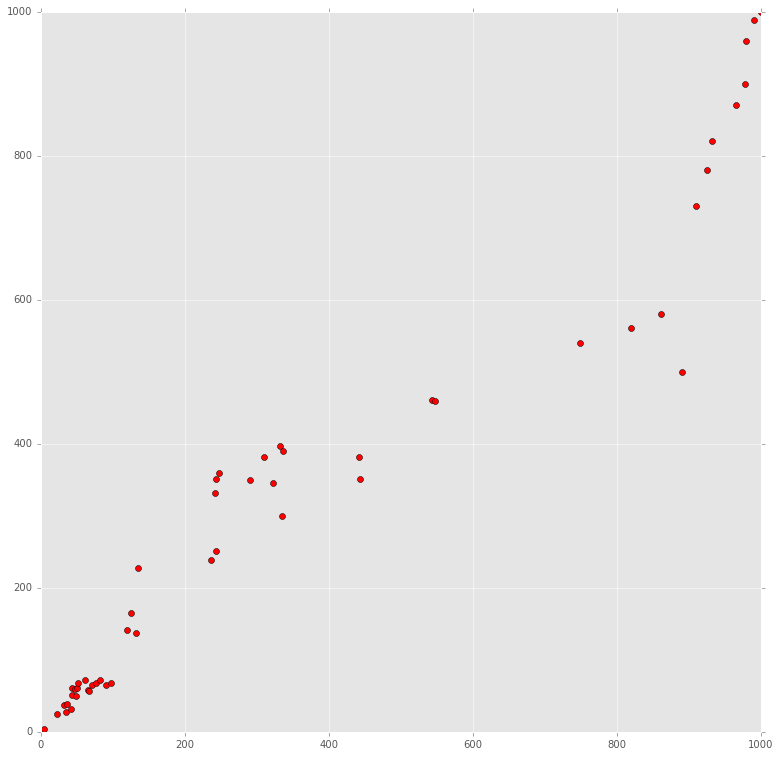

In [38]:
fig1 = plt.figure()
fig1.set_size_inches(10,10)
ax1 = fig1.add_axes([0, 0, 1, 1])
ax1.plot(_xo['0'], _xo['1'], 'ro')


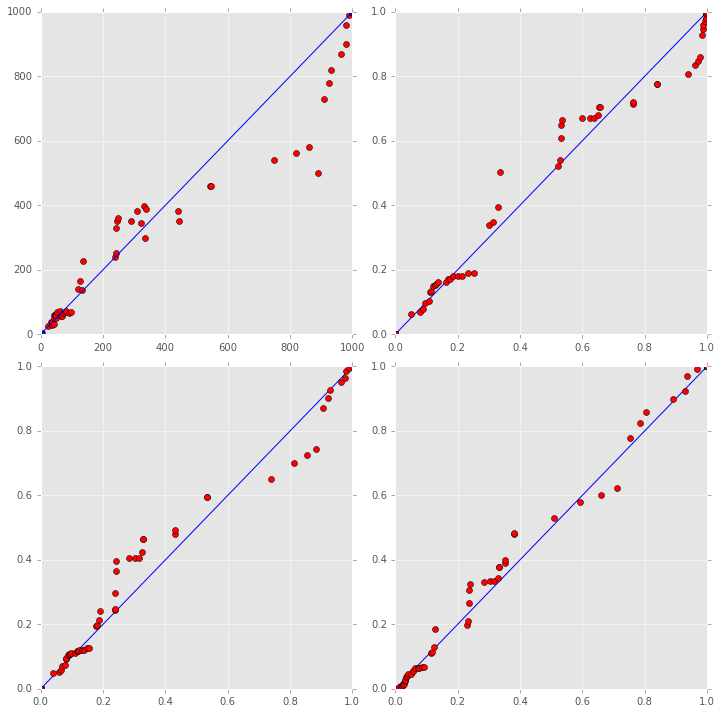

In [39]:
plt.close('all')
fig1, ((sp1, sp2), (sp3, sp4)) = plt.subplots(2, 2)
fig1.set_size_inches(10,10)
plt.tight_layout()
sp1.plot(_xo['0'], _xo['1'], 'ro')
sp1.plot([0, 1000], [0, 1000], 'bs-')
#sp2.plot([0.0, 0.0], [1.0, 1.0], color='r', linestyle='-', linewidth=2)
sp2.plot([0, 1], [0, 1], 'bs-')
sp2.plot(_xt2['0'], _xt2['1'], 'ro')
sp3.plot([0, 1], [0, 1], 'bs-')
sp3.plot(_xt4['0'], _xt4['1'], 'ro')
sp4.plot([0, 1], [0, 1], 'bs-')
sp4.plot(_xt5['0'], _xt5['1'], 'ro')

In [40]:
xts = [_xo, _xt2, _xt4, _xt5]
for xt in xts:
    xtd = abs(xt['0'] - xt['1'])
    xts = abs(xt['0'] + xt['1'] - 1)
    print(1 - xtd.sum() / xts.sum(), ((xts.sum() - xtd.sum()) / (xts.sum() + xtd.sum()) ))
    

0.909227550027998 0.8335629947853341
0.931006222271567 0.8709182800389319
0.9332035320198221 0.8747718613904915
0.9604705259474129 0.9239473722693361


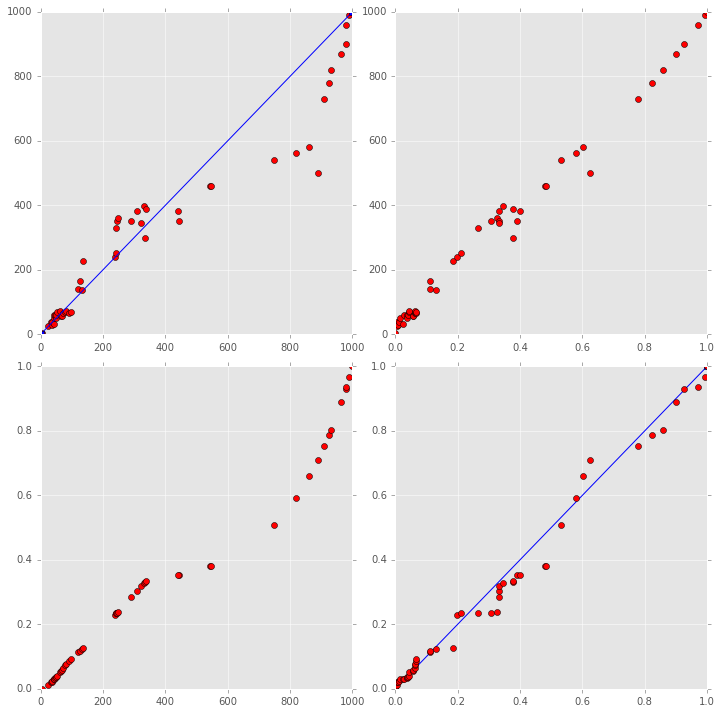

In [41]:
fig2, ((sp21, sp22), (sp23, sp24)) = plt.subplots(2, 2)
fig2.set_size_inches(10,10)
plt.tight_layout()
sp21.plot(_xo['0'], _xo['1'], 'ro')
sp21.plot([0, 1000], [0, 1000], 'bs-')
sp22.plot(_xt5['1'], _xo['1'], 'ro')
sp23.plot(_xo['0'], _xt5['0'], 'ro')
sp24.plot([0, 1], [0, 1], 'bs-')
sp24.plot(_xt5['1'], _xt5['0'], 'ro')

In [42]:
xt

,0,1
0,0.000000,0.000000
1,0.011622,0.005607
2,0.019738,0.006489
3,0.022383,0.008521
4,0.024203,0.012387
5,0.028963,0.013937
6,0.029952,0.025643
7,0.030954,0.027039
8,0.034038,0.036947
9,0.036160,0.038887
